In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt
import pathlib
import os

AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.keras.backend.clear_session()  # For easy reset of notebook state.

tf.__version__
tf.executing_eagerly()


True

In [59]:

ds = tfds.load(name="imagenette", with_info=True, split=["train","validation"])
ds_train=ds[0][0]
ds_test=ds[0][1]
assert isinstance(ds_train, tf.data.Dataset)

def normalize(x):
    y = {'image': tf.image.convert_image_dtype(x['image'], tf.float32), 'label': x['label']}
    y = (tf.image.resize(y['image'], (224,224)), y['label'])
    return y
    
ds_train = ds_train.map(lambda x: normalize(x))
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(100)
ds_train = ds_train.batch(8)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(8)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

(3, 50176)
(224, 224, 3)


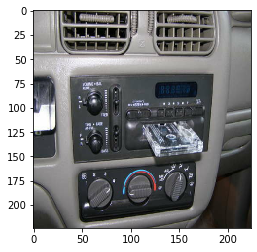

In [60]:


shape=(50176,3)
y = unroll(x, shape)
print(y.shape)
shape=(224,224,3)
z = roll_back(y, shape)
print(z.shape)
def unroll(tensor, shape):
    return tf.transpose(tf.reshape(tensor, shape))

def roll_back(tensor, shape):
    return(tf.reshape(tf.transpose(tensor), shape))

plt.figure()
plt.imshow(z)
plt.show()

tf.Tensor(2, shape=(), dtype=int64)
(224, 224, 3)


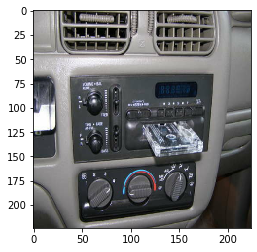

In [61]:
for z in ds_test.take(1):
    print(z[1][0])
    print(z[0][0].shape)
    x = z[0][0].numpy()
    tf.reshape
    plt.figure()
    plt.imshow(x)
    plt.show()

In [3]:
#conv2D with bias and relu activation

class CustomConvLayer(layers.Layer):

    def __init__(self, weights, mask, biases, stride=1, padding='SAME'):
        
        super(CustomConvLayer, self).__init__()
        self.w = weights
        self.m = mask
        self.b = biases
        self.s = stride
        self.p = padding

        
    def call(self, inputs):
        x = tf.nn.conv2d(inputs, tf.multiply(self.w, self.m), strides=[1, self.s, self.s, 1], padding=self.p)
        x = tf.nn.bias_add(x, self.b)
        return tf.nn.relu(x)
    
#Dense Layer with Bias
class CustomDenseLayer(layers.Layer):
    
    def __init__(self, weights, mask, bias, activation = 'relu'):
        super(CustomDenseLayer, self).__init__()
        self.w = weights
        self.b = bias
        self.a = activation
        self.m = mask
        
    def call(self, inputs):
        #print('dense w',self.w)
        #print('dense i',inputs)
        x = tf.matmul(inputs, tf.multiply(self.w, self.m))
        #print('dense x',x)
        x = tf.nn.bias_add(x, self.b)
        if self.a == 'relu':
            return tf.nn.relu(x)
        if self.a == 'softmax':
            return tf.nn.softmax(x)


    
class ResNetBlock(tf.keras.layers.Layer):
    def __init__(self, input_channels=3 ,output_channels = 64, stride=1):
        super(ResNetBlock, self).__init__()
        self.stride = stride
        #self.conv1 = layers.Conv2D(filters, 3, strides=(self.stride, self.stride), activation='relu', padding='same')
        self.conv1 = CustomConvLayer(tf.Variable(tf.keras.initializers.glorot_uniform()([3, 3, input_channels, output_channels])),
                                     tf.Variable(tf.ones([3, 3, input_channels, output_channels]), trainable=False),
                                     tf.Variable(tf.zeros([output_channels]))
                                    )
        self.bn1 = layers.BatchNormalization()
        #self.conv2 = layers.Conv2D(filters, 3, padding='same')
        self.conv2 = CustomConvLayer(tf.Variable(tf.keras.initializers.glorot_uniform()([3, 3, output_channels, output_channels])),
                                     tf.Variable(tf.ones([3, 3, output_channels, output_channels]), trainable=False),
                                     tf.Variable(tf.zeros([output_channels]))
                                    )
        self.bn2 = layers.BatchNormalization()
        if stride == 2:
            self.conv3 = CustomConvLayer(tf.Variable(tf.keras.initializers.glorot_uniform()([1, 1, output_channels, output_channels])),
                                         tf.Variable(tf.ones([1, 1, output_channels, output_channels]), trainable=False),
                                         tf.Variable(tf.zeros([output_channels])),
                                         stride=self.stride)
            self.bn3 = layers.BatchNormalization()
        self.add1 = layers.Add()
    
    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        if self.stride == 2:
            inputs = self.conv3(x)
            inputs = self.bn3(x)
        return tf.nn.relu(self.add1([x, inputs]))
    

class CustomResNetModel(tf.keras.Model):
    def __init__(self):
        super(CustomResNetModel, self).__init__()
        #self.conv1 = layers.Conv2D(64, 7, strides=(2, 2), padding='same')
        self.conv1 = CustomConvLayer(tf.Variable(tf.keras.initializers.glorot_uniform()([7, 7, 3, 64])),
                                     tf.Variable(tf.ones([7, 7, 3, 64]), trainable=False),
                                     tf.Variable(tf.zeros([64])),
                                     stride=2)
        self.pool1 = layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')
        self.res_block1 = ResNetBlock(64, 64)
        #self.res_block2 = ResNetBlock(64, 64)
        self.res_block3 = ResNetBlock(64, 64)
        self.res_block4 = ResNetBlock(64, 128, 2)
        #self.res_block5 = ResNetBlock(128, 128)
        #self.res_block6 = ResNetBlock(128, 128)
        self.res_block7 = ResNetBlock(128, 128)
        self.res_block8 = ResNetBlock(128, 256, 2)
        #self.res_block9 = ResNetBlock(256, 256)
        #self.res_block10 = ResNetBlock(256, 256)
        #self.res_block11 = ResNetBlock(256, 256)
        #self.res_block12 = ResNetBlock(256, 256)
        self.res_block13 = ResNetBlock(256, 256)
        self.res_block14 = ResNetBlock(256 ,512, 2)
        #self.res_block15 = ResNetBlock(512, 512)
        self.res_block16 = ResNetBlock(512, 512)
        self.pool2 = layers.GlobalAveragePooling2D()
        self.dense1 = CustomDenseLayer(
            tf.Variable(tf.keras.initializers.glorot_uniform()([512, 1000])),
            tf.Variable(tf.ones([512, 1000]), trainable=False),
            tf.Variable(tf.zeros([1000])),
        )
        self.dense2 = CustomDenseLayer(
            tf.Variable(tf.keras.initializers.glorot_uniform()([1000, 10])),
            tf.Variable(tf.ones([1000, 10]), trainable=False),
            tf.Variable(tf.zeros([10])),
            activation='softmax'
        )

    def call(self,inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.res_block1(x)
        #x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        #x = self.res_block5(x)
        #x = self.res_block6(x)
        x = self.res_block7(x)
        x = self.res_block8(x)
        #x = self.res_block9(x)
        #x = self.res_block10(x)
        #x = self.res_block11(x)
        #x = self.res_block12(x)
        x = self.res_block13(x)
        x = self.res_block14(x)
        #x = self.res_block15(x)
        x = self.res_block16(x)
        x = self.pool2(x)
        x = self.dense1(x)
        
        return self.dense2(x)

21439680

In [4]:
model = CustomResNetModel()

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)


In [37]:
model.fit(
    x=ds_train,
    #steps_per_epoch=1,
    epochs=3,
    validation_data=ds_test,
)
model.run_eagerly = False

Epoch 1/3


1612/1612 [==============================] - 817s 507ms/step - loss: 2.0603 - accuracy: 0.2648 - val_loss: 2.5609 - val_accuracy: 0.1420
Epoch 2/3
1612/1612 [==============================] - 788s 489ms/step - loss: 1.7746 - accuracy: 0.3775 - val_loss: 1.7329 - val_accuracy: 0.4320
Epoch 3/3
1612/1612 [==============================] - 795s 493ms/step - loss: 1.6349 - accuracy: 0.4328 - val_loss: 2.6725 - val_accuracy: 0.3620


In [6]:
model.summary()

Model: "custom_res_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
custom_conv_layer (CustomCon multiple                  18880     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
res_net_block (ResNetBlock)  multiple                  148096    
_________________________________________________________________
res_net_block_1 (ResNetBlock multiple                  148096    
_________________________________________________________________
res_net_block_2 (ResNetBlock multiple                  477056    
_________________________________________________________________
res_net_block_3 (ResNetBlock multiple                  591104    
_________________________________________________________________
res_net_block_4 (ResNetBlock multiple         

In [22]:
(21978576)-16896

21961680

21961282

In [ ]:
glorot_uniform_initializer = tf.keras.initializers.glorot_uniform()
x = glorot_uniform_initializer((3, 3, 64, 64))

In [ ]:
tf.Variable(x)

In [63]:
base_model = tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 31s 0us/step


In [64]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(10)


In [65]:
transfer_model  = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [74]:
base_learning_rate = 0.0001
transfer_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [75]:
history = transfer_model.fit(ds_train,
                    epochs=10,
                    validation_data=ds_test)

Epoch 1/10
1612/1612 [==============================] - 6113s 4s/step - loss: 0.3860 - accuracy: 0.8818 - val_loss: 1.3413 - val_accuracy: 0.8380
Epoch 2/10
1612/1612 [==============================] - 5738s 4s/step - loss: 0.1597 - accuracy: 0.9504 - val_loss: 0.5337 - val_accuracy: 0.8920
Epoch 3/10
1612/1612 [==============================] - 5592s 3s/step - loss: 0.0984 - accuracy: 0.9685 - val_loss: 0.2604 - val_accuracy: 0.9400
Epoch 4/10
 677/1612 [===========>..................] - ETA: 53:21 - loss: 0.0601 - accuracy: 0.9822

KeyboardInterrupt: 